# Péter és a farkas: Bevezetés a megerősítéses tanulásba

Ebben az oktatóanyagban megtanuljuk, hogyan alkalmazzuk a megerősítéses tanulást egy útvonal-keresési problémára. A környezetet [Péter és a farkas](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) című zenés mese ihlette, amelyet az orosz zeneszerző, [Szergej Prokofjev](https://en.wikipedia.org/wiki/Sergei_Prokofiev) alkotott. Ez egy történet a fiatal úttörőről, Péterről, aki bátran elhagyja házát, hogy az erdei tisztáson üldözze a farkast. Gépi tanulási algoritmusokat fogunk betanítani, amelyek segítenek Péternek felfedezni a környező területet és megalkotni egy optimális navigációs térképet.

Először importáljunk néhány hasznos könyvtárat:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## A megerősítéses tanulás áttekintése

A **megerősítéses tanulás** (RL) egy olyan tanulási technika, amely lehetővé teszi számunkra, hogy egy **ügynök** optimális viselkedését tanuljuk meg egy adott **környezetben**, számos kísérlet lefuttatásával. Az ügynöknek ebben a környezetben kell, hogy legyen valamilyen **célja**, amelyet egy **jutalomfüggvény** határoz meg.

## A környezet

Egyszerűség kedvéért tekintsük Péter világát egy `width` x `height` méretű négyzet alakú táblának. A tábla minden cellája lehet:
* **talaj**, amin Péter és más lények sétálhatnak
* **víz**, amin nyilvánvalóan nem lehet sétálni
* **fa** vagy **fű** - egy hely, ahol pihenni lehet
* **alma**, amely valami olyasmit jelképez, amit Péter szívesen találna meg, hogy táplálkozhasson
* **farkas**, amely veszélyes, és el kell kerülni

A környezettel való munka érdekében definiálunk egy `Board` nevű osztályt. Annak érdekében, hogy ne zsúfoljuk túl ezt a jegyzetfüzetet, az összes táblával kapcsolatos kódot egy külön `rlboard` modulba helyeztük át, amelyet most importálunk. Ha szeretnéd, megtekintheted ennek a modulnak a belsejét, hogy részletesebb információkat kapj a megvalósítás belső működéséről.


In [2]:
from rlboard import *

Most hozzunk létre egy véletlenszerű táblát, és nézzük meg, hogyan néz ki:


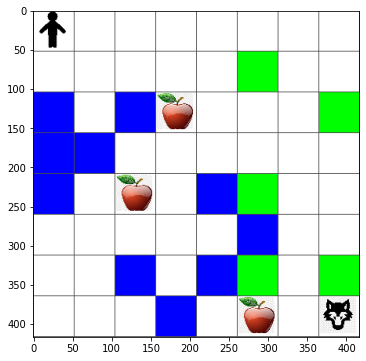

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Tevékenységek és Szabályok

Példánkban Péter célja, hogy találjon egy almát, miközben elkerüli a farkast és más akadályokat. Ehhez lényegében addig sétálgathat, amíg meg nem talál egy almát. Ezért bármelyik pozícióban választhat a következő tevékenységek közül: fel, le, balra és jobbra. Ezeket a tevékenységeket egy szótárként fogjuk definiálni, és a megfelelő koordinátaváltozások párjaihoz rendeljük. Például a jobbra mozgás (`R`) egy `(1,0)` párnak felelne meg.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Ügynökünk (Péter) stratégiáját egy úgynevezett **politika** határozza meg. Vegyük szemügyre a legegyszerűbb politikát, amelyet **véletlenszerű séta** néven ismerünk.

## Véletlenszerű séta

Először oldjuk meg a problémánkat egy véletlenszerű séta stratégia megvalósításával.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Futtassuk le a véletlenszerű bolyongás kísérletet többször, és nézzük meg az átlagos lépésszámot:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Jutalomfüggvény

Ahhoz, hogy a stratégiánk intelligensebb legyen, meg kell értenünk, mely lépések "jobbak", mint mások.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Hozzunk létre egy Q-táblát, vagyis egy többdimenziós tömböt. Mivel a táblánk mérete `szélesség` x `magasság`, a Q-táblát egy numpy tömbbel ábrázolhatjuk, amelynek alakja `szélesség` x `magasság` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Adja át a Q-táblázatot a plot függvénynek, hogy megjelenítse a táblázatot a táblán:


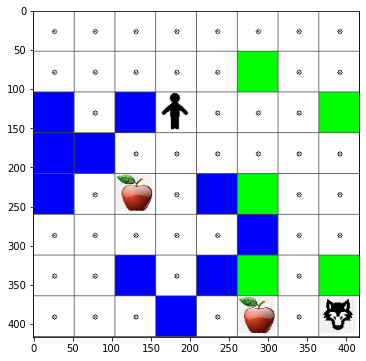

In [9]:
m.plot(Q)

## A Q-Learning lényege: Bellman-egyenlet és tanulási algoritmus

Írj egy pszeudokódot a tanulási algoritmusunkhoz:

* Inicializáld a Q-táblát Q azonos értékekkel minden állapothoz és cselekvéshez
* Állítsd be a tanulási rátát $\alpha\leftarrow 1$
* Ismételd meg a szimulációt sokszor
   1. Kezdj véletlenszerű pozícióban
   1. Ismételd
        1. Válassz egy cselekvést $a$ az állapotban $s$
        2. Hajtsd végre a cselekvést, és lépj egy új állapotba $s'$
        3. Ha találkozunk a játék végének feltételével, vagy a teljes jutalom túl kicsi - lépj ki a szimulációból  
        4. Számítsd ki a jutalmat $r$ az új állapotban
        5. Frissítsd a Q-függvényt a Bellman-egyenlet szerint: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Frissítsd a teljes jutalmat, és csökkentsd $\alpha$ értékét.

## Kihasználás vs. Felfedezés

A legjobb megközelítés az, ha egyensúlyt tartunk a felfedezés és a kihasználás között. Ahogy egyre többet tanulunk a környezetünkről, valószínűbb, hogy az optimális útvonalat követjük, azonban időnként érdemes az ismeretlen utat választani.

## Python implementáció

Most készen állunk a tanulási algoritmus megvalósítására. Előtte szükségünk van egy olyan függvényre, amely a Q-táblában lévő tetszőleges számokat átalakítja a megfelelő cselekvések valószínűségi vektorává:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Egy kis mennyiségű `eps` értéket adunk az eredeti vektorhoz, hogy elkerüljük a nullával való osztást az induló esetben, amikor a vektor összes komponense azonos.

A tényleges tanulási algoritmust 5000 kísérletre futtatjuk, amelyeket **epochoknak** is nevezünk:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Az algoritmus végrehajtása után a Q-táblát frissíteni kell olyan értékekkel, amelyek meghatározzák a különböző lépések vonzerejét minden egyes lépésnél. Vizualizálja a táblát itt:


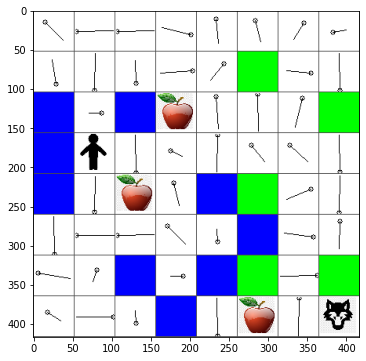

In [12]:
m.plot(Q)

## A szabályzat ellenőrzése

Mivel a Q-Table felsorolja az egyes állapotokban az egyes cselekvések "vonzóságát", nagyon egyszerű ezt felhasználni a hatékony navigáció meghatározására a világunkban. A legegyszerűbb esetben egyszerűen kiválaszthatjuk azt a cselekvést, amely a legmagasabb Q-Table értékhez tartozik:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Ha többször futtatod a fenti kódot, észreveheted, hogy néha egyszerűen "lefagy", és meg kell nyomnod a STOP gombot a notebookban, hogy megszakítsd.

> **1. feladat:** Módosítsd a `walk` függvényt úgy, hogy korlátozza az útvonal maximális hosszát egy bizonyos lépésszámmal (például 100), és figyeld meg, hogy a fenti kód időnként visszaadja ezt az értéket.

> **2. feladat:** Módosítsd a `walk` függvényt úgy, hogy ne térjen vissza olyan helyekre, ahol már korábban járt. Ez megakadályozza, hogy a `walk` ciklusba kerüljön, azonban az ügynök még mindig "csapdába" eshet egy olyan helyen, ahonnan nem tud kijutni.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


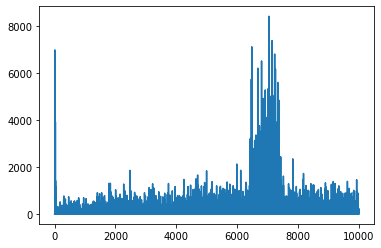

In [15]:
plt.plot(lpath)

Amit itt látunk, az az, hogy kezdetben az átlagos útvonalhossz megnőtt. Ez valószínűleg annak köszönhető, hogy amikor semmit sem tudunk a környezetről, hajlamosak vagyunk rossz állapotokba kerülni, például vízbe vagy farkasok közé. Ahogy egyre többet tanulunk, és elkezdjük használni ezt a tudást, hosszabb ideig tudjuk felfedezni a környezetet, de még mindig nem tudjuk pontosan, hol vannak az almák.

Amint eleget tanulunk, az ügynök számára könnyebbé válik a cél elérése, és az útvonal hossza csökkenni kezd. Azonban még mindig nyitottak vagyunk a felfedezésre, így gyakran eltérünk az optimális úttól, és új lehetőségeket vizsgálunk meg, ami az útvonalat hosszabbá teszi, mint az ideális.

A grafikonon azt is megfigyelhetjük, hogy egy ponton az útvonal hossza hirtelen megnőtt. Ez a folyamat sztochasztikus természetére utal, és arra, hogy bizonyos pontokon "elronthatjuk" a Q-tábla együtthatóit, ha új értékekkel írjuk felül őket. Ezt ideális esetben minimalizálni kellene a tanulási ráta csökkentésével (azaz a tréning végéhez közeledve csak kis értékekkel módosítjuk a Q-tábla értékeit).

Összességében fontos megjegyezni, hogy a tanulási folyamat sikere és minősége jelentősen függ olyan paraméterektől, mint a tanulási ráta, a tanulási ráta csökkenése és a diszkontfaktor. Ezeket gyakran **hiperparamétereknek** nevezzük, hogy megkülönböztessük őket azoktól a **paraméterektől**, amelyeket a tréning során optimalizálunk (pl. a Q-tábla együtthatói). Az optimális hiperparaméter-értékek megtalálásának folyamatát **hiperparaméter-optimalizációnak** nevezzük, és ez egy külön témát érdemel.


## Feladat
#### Egy reálisabb Péter és a farkas világ

A mi helyzetünkben Péter szinte fáradtság és éhség nélkül tudott mozogni. Egy reálisabb világban időnként le kell ülnie pihenni, és ennie is kell. Tegyük a világunkat reálisabbá az alábbi szabályok megvalósításával:

1. Ha Péter egyik helyről a másikra mozog, **energiát** veszít és **fáradtságot** szerez.
2. Péter több energiát nyerhet, ha almát eszik.
3. Péter megszabadulhat a fáradtságtól, ha pihen a fa alatt vagy a füvön (azaz ha olyan mezőre lép, ahol fa vagy fű van - zöld mező).
4. Péternek meg kell találnia és meg kell ölnie a farkast.
5. Ahhoz, hogy Péter legyőzze a farkast, bizonyos szintű energiával és fáradtsággal kell rendelkeznie, különben elveszíti a csatát.

Módosítsd a fentebb található jutalomfüggvényt a játék szabályai szerint, futtasd a megerősítéses tanulási algoritmust, hogy megtanulja a legjobb stratégiát a játék megnyeréséhez, és hasonlítsd össze az eredményeket a véletlenszerű lépések eredményeivel a megnyert és elveszített játékok számát tekintve.

> **Megjegyzés**: Lehet, hogy módosítanod kell a hiperparamétereket, hogy működjön, különösen az epochok számát. Mivel a játék sikere (a farkassal való harc) ritka esemény, sokkal hosszabb tanulási időre számíthatsz.



---

**Felelősségkizárás**:  
Ez a dokumentum az [Co-op Translator](https://github.com/Azure/co-op-translator) AI fordítási szolgáltatás segítségével készült. Bár törekszünk a pontosságra, kérjük, vegye figyelembe, hogy az automatikus fordítások hibákat vagy pontatlanságokat tartalmazhatnak. Az eredeti dokumentum az eredeti nyelvén tekintendő hiteles forrásnak. Kritikus információk esetén javasolt a professzionális, emberi fordítás igénybevétele. Nem vállalunk felelősséget a fordítás használatából eredő félreértésekért vagy téves értelmezésekért.
